# Programa Ingenias+ Data Science

## Objetivo del notebook

El objetivo de este notebook es aplicar y comparar técnicas de aprendizaje no supervisado, tanto de clustering como de reducción de dimensionalidad, para identificar patrones y estructuras subyacentes en los datos.

Las columnas de características que se utilizarán en el notebook se detallan a continuación.


## Importación de archivos y librerías

In [1]:
# Imports de librerías y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from utils.codificaciones import *
from utils.funcions import *

In [17]:
# Importar el csv
friesgo_raw = pd.read_csv('datasets/friesgo.csv')

In [41]:
friesgo_raw2 = pd.read_csv('datasets/friesgo_2018.csv')

In [42]:
friesgo_raw2.shape

(29224, 218)

## Preprocesado

### Identificación de variables

In [ ]:
# aca ponemos las columnas de cada bloque que sean relevantes y con un 50+% de datos utiles
variables_para_ns = {
'cod_provincia','tamanio_aglomerado','submuestra',
}
# despues filtramos friesgo_2018_raw que es lo que se importa arriba en lugar de friesgo_2018_analisis

In [23]:
# Separar variables categóricas y numéricas
variables_categoricas = ['cod_provincia','tamanio_aglomerado','sexo','condicion_actividad','ansiedad_depresion'
                           ,'nivel_actividad_fisica','condicion_fumador','consumo_sal'
                           ,'colesterol_alto','freq_cons_alc','es_diabetico','mantiene_ha_alta']
variables_numericas = ['edad','media_fv_diaria','imc_numerico']

In [4]:
# Selección de columnas
friesgo = friesgo_raw[['cod_provincia','tamanio_aglomerado','sexo','condicion_actividad','ansiedad_depresion',
           'nivel_actividad_fisica','condicion_fumador','consumo_sal','colesterol_alto',
           'freq_cons_alc','es_diabetico','mantiene_ha_alta', 'edad','media_fv_diaria',
           'imc_numerico']]

In [19]:
# Copiar el dataframe
friesgo_cod = friesgo_raw2.copy()

In [20]:
friesgo_cod.shape

(29224, 93)

### Evaluación y procesamiento de nulos

In [13]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
submuestra,0,0.0%
sexo,0,0.0%
...,...,...
imc_autoreportado,2229,7.63%
imc_categorias_autoreportado,0,0.0%
imc_numerico,705,2.41%
imc_clasificacion,0,0.0%


In [14]:
# Eliminación de nulos
friesgo_cod = friesgo_cod.dropna()

In [16]:
friesgo_cod.shape

(0, 93)

In [36]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,nan%
cod_provincia,0,nan%
tamanio_aglomerado,0,nan%
submuestra,0,nan%
sexo,0,nan%
...,...,...
imc_autoreportado,0,nan%
imc_categorias_autoreportado,0,nan%
imc_numerico,0,nan%
imc_clasificacion,0,nan%


### Codificación de columnas

In [21]:
# Visualización de filas y columnas
friesgo_cod.shape

(29224, 93)

In [28]:
# Codificación de columnas
le = LabelEncoder()
for columnas in friesgo_cod:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [29]:
# Evaluar que no haya pérdida de filas y/o columnas por la codificación
friesgo_cod.shape

(29224, 93)

## Reduccion de dimensionalidad

### Metodo Manual : Permutation importance

Se aplicara un algoritmo de clasificacion Random forest para sobre este poder medir la importancia de las caracteristicas/features/columnas del dataset para decidir cuales son las mas importantes para posteriormente realizar una reduccion de dimensionalidad eliminando las columnas cuyas importancias esten representadas por porcentajes bajos.

In [30]:
# Separo los conjuntos para entrenamiento y testeo
y = friesgo_cod['mantiene_ha_alta']
X = friesgo_cod.drop(columns=['mantiene_ha_alta'])
X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Entreno el modelo para tener los parametros de accuracy de base
modelo = RandomForestClassifier(random_state=42,criterion= 'gini', n_estimators=200, max_depth=8)
# Ajusto el modelo
modelo.fit(X_train_pi, y_train_pi)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [33]:
# Calculo el acurracy base
y_pred_pi = modelo.predict(X_test_pi)
acc = accuracy_score(y_test_pi, y_pred_pi)
acc

0.994183394160584

In [34]:
# Calculo Permutation Importance
perm = permutation_importance(modelo, X_test_pi, y_test_pi,random_state=1)

In [35]:
# Ordeno las caracteristicas por importancia promedio
indices = np.argsort(perm.importances_mean)[::-1]  # Orden descendente
features = X_test_pi.columns[indices]
importances = perm.importances_mean[indices]
importances_std = perm.importances_std[indices]

In [38]:
features

Index(['hay_medicion_ha', 'tiempo_ultima_medicion_ha', 'obesidad',
       'af_fue_deporte', 'tiempo_sentado_min_por_dia',
       'tiempo_sentado_min_por_dia_nsnc',
       'razon_ninguna_actividad_la_ultima_semana',
       'razon_poca_actividad_la_ultima_semana', 'af_fue_actividad_domestica',
       'af_fue_actividad_laboral', 'af_fue_traslado', 'nivel_actividad_fisica',
       'caminata_min_totales_por_semana', 'barreras_actividad_fisica',
       'condicion_fumador', 'edad_fuma_primera_vez', 'fumado_100_cigarrillos',
       'periodicidad_fumador', 'cant_tipos_tabaco', 'es_diabetico',
       'es_diabetes_gestacional', 'en_tratamiento_diabetes',
       'caminata_min_totales_por_semana_nsnc', 'caminata_veces_por_semana',
       'diagnostico_cosanguineos_ns_nc', 'salud_actual', 'cod_provincia',
       'tamanio_aglomerado', 'submuestra', 'sexo', 'edad',
       'situacion_conyugal', 'nivel_educ', 'cobertura_salud',
       'condicion_actividad', 'nivel_de_movilidad',
       'actividad_fisica_

In [37]:
importances

array([0.05061588, 0.04637318, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

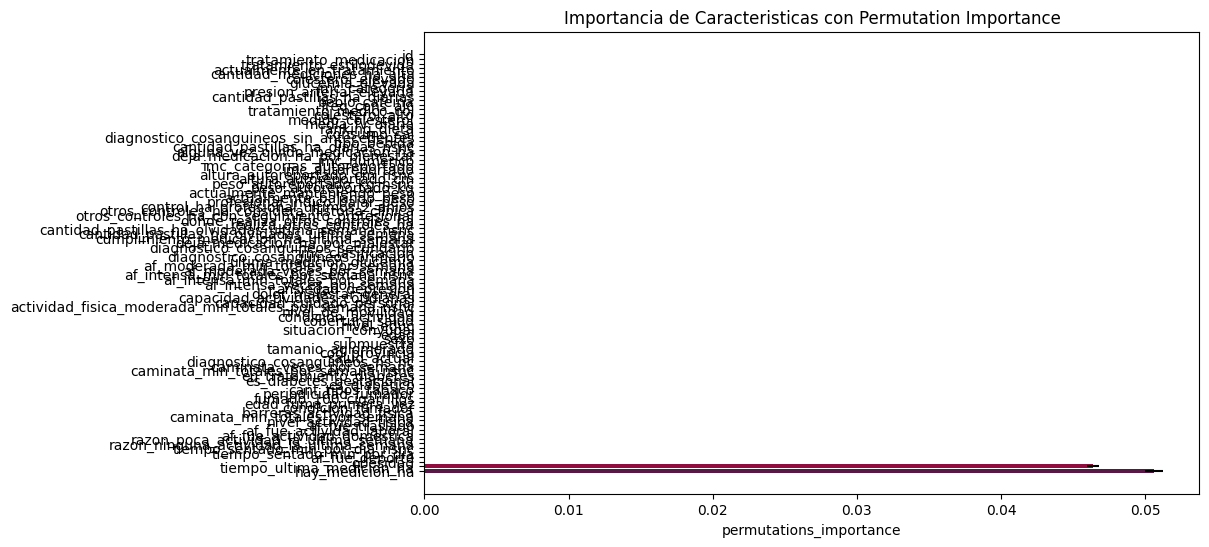

In [36]:
# Creo el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(features, importances, xerr=importances_std, align='center',color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.xlabel('permutations_importance')
plt.title('Importancia de Caracteristicas con Permutation Importance')
plt.show()

### Metodo por Algoritmo No Supervisado

### Estandarizar datos

PCA es sensible a la escala de las columnas. La estandarización asegura que cada característica contribuya igualmente al análisis.

In [ ]:
# Estandarización de los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(friesgo_cod)

### Evaluar el número óptimo de componentes para PCA

Para conservar el 95% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [ ]:
pca = PCA(n_components = 0.95)
pca_data = pca.fit_transform(scaled_data)
n_components = pca.n_components_

# Ver el número de componentes seleccionados automáticamente
print(f"Número de componentes seleccionados: {n_components}")

Número de componentes seleccionados: 14


### Aplicar PCA 

Para conservar el 95% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [ ]:
# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components = n_components)
pca_opt_data = pca_opt.fit_transform(scaled_data)

# Convertir a DataFrame para facilitar el manejo
pca_df = pd.DataFrame(data = pca_opt_data, columns = [f'PC{i+1}' for i in range(n_components)])

### Visualizar la varianza explicada 

Permite ver cómo cada componente principal contribuye a la varianza total y cómo se acumula la varianza explicada.

In [ ]:
# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por cada componente principal
print('Varianza explicada')
for i in range(n_components):
    print('PC{}: {}'.format(i+1, pca.explained_variance_ratio_[i]))

Varianza explicada
PC1: 0.15556035687712857
PC2: 0.09267600381227904
PC3: 0.0896310891536627
PC4: 0.07784959576674855
PC5: 0.06898888886702716
PC6: 0.06411838031114755
PC7: 0.060503448413836425
PC8: 0.056894984375953056
PC9: 0.05504170396580302
PC10: 0.053452053314127924
PC11: 0.05190839933107017
PC12: 0.049530084060620726
PC13: 0.04708515673377828
PC14: 0.04337426475990944


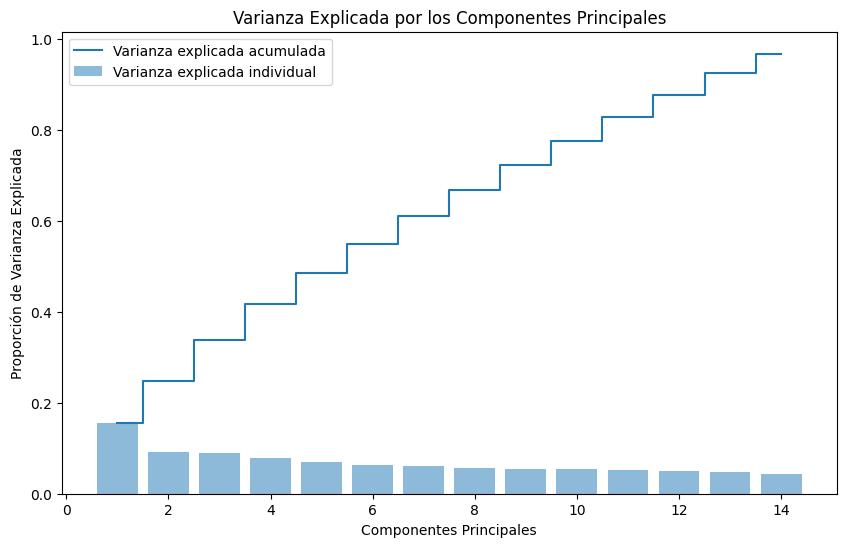

In [ ]:
# Visualización de la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(1, len(np.cumsum(explained_variance)) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por los Componentes Principales')
plt.legend(loc='best')
plt.show()

## Análisis de modelos

### Modelo 1: K-Means

In [ ]:
# test codo

### Modelo 2: DBSCAN